In [1]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"

In [2]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')

2025-02-28 01:04:42.609467: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-28 01:04:42.617850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740704682.627506   11829 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740704682.630287   11829 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-28 01:04:42.640961: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
os.environ["TF_CUDNN_USE_AUTOTUNE"] = "0"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle
import json
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = filter INFO, 2 = filter INFO & WARNING, 3 = only ERROR

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

sns.set_theme(style='white', palette=None)
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
import keras

2025-02-28 01:13:53.779649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740705233.789153   12539 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740705233.791975   12539 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
'''
To load the training/ testing data and prepare them to be used by the model:
1.Open the HDF5 file and get the list of all song groups.
2.Shuffle the song list and split it into training and testing groups (80/20 split).
3.For each song in training (and testing), load its target vector and all its segments.
4.Flatten the data:
Each segment from a song becomes one training sample, and its target is the same as the song's target.
5.Return the data arrays (and optionally the list of song names).
'''

"\nTo load the training/ testing data and prepare them to be used by the model:\n1.Open the HDF5 file and get the list of all song groups.\n2.Shuffle the song list and split it into training and testing groups (80/20 split).\n3.For each song in training (and testing), load its target vector and all its segments.\n4.Flatten the data:\nEach segment from a song becomes one training sample, and its target is the same as the song's target.\n5.Return the data arrays (and optionally the list of song names).\n"

In [4]:
'''
This only works if you have a lot of RAM (64 GB and above), otherwise, need to load the data with a generator
import h5py
import numpy as np

def load_train_test_from_h5(h5_file_path, train_ratio=0.8, random_seed=42):
    """
    Loads song data from the HDF5 file, randomly splits the songs into training and testing sets,
    and then flattens each song's segments into training samples.
    
    Returns:
      X_train, y_train: numpy arrays of training spectrograms and their target vectors.
      X_test, y_test: numpy arrays of testing spectrograms and their target vectors.
      train_songs, test_songs: Lists of song names used in training and testing.
    """
    with h5py.File(h5_file_path, "r") as f:
        # Get list of song names (the groups)
        all_songs = list(f.keys())
        # Shuffle the list for a random split
        np.random.seed(random_seed)
        np.random.shuffle(all_songs)
        
        num_train = int(len(all_songs) * train_ratio)
        train_songs = all_songs[:num_train]
        test_songs = all_songs[num_train:]
        
        X_train_list = []
        y_train_list = []
        for song in train_songs:
            grp = f[song]
            # Load the target vector (stored as a dataset "target")
            target = grp["target"][:]  # e.g., shape (8,)
            # Load each segment in the "segments" subgroup
            segments = [grp["segments"][seg_key][:] for seg_key in grp["segments"].keys()]
            # For each segment, append the same target vector
            for seg in segments:
                X_train_list.append(seg)
                y_train_list.append(target)
        
        X_test_list = []
        y_test_list = []
        for song in test_songs:
            grp = f[song]
            target = grp["target"][:]
            segments = [grp["segments"][seg_key][:] for seg_key in grp["segments"].keys()]
            for seg in segments:
                X_test_list.append(seg)
                y_test_list.append(target)
                
    # Convert lists to numpy arrays
    X_train = np.array(X_train_list)
    y_train = np.array(y_train_list)
    X_test = np.array(X_test_list)
    y_test = np.array(y_test_list)
    
    return X_train, y_train, X_test, y_test, train_songs, test_songs
'''

'\nThis only works if you have a lot of RAM (64 GB and above), otherwise, need to load the data with a generator\nimport h5py\nimport numpy as np\n\ndef load_train_test_from_h5(h5_file_path, train_ratio=0.8, random_seed=42):\n    """\n    Loads song data from the HDF5 file, randomly splits the songs into training and testing sets,\n    and then flattens each song\'s segments into training samples.\n    \n    Returns:\n      X_train, y_train: numpy arrays of training spectrograms and their target vectors.\n      X_test, y_test: numpy arrays of testing spectrograms and their target vectors.\n      train_songs, test_songs: Lists of song names used in training and testing.\n    """\n    with h5py.File(h5_file_path, "r") as f:\n        # Get list of song names (the groups)\n        all_songs = list(f.keys())\n        # Shuffle the list for a random split\n        np.random.seed(random_seed)\n        np.random.shuffle(all_songs)\n        \n        num_train = int(len(all_songs) * train_ratio

In [5]:
import h5py
import numpy as np
import tensorflow as tf

def get_total_song_count(h5_file_path):
    """Return the list of all song names in the HDF5 file."""
    with h5py.File(h5_file_path, "r") as f:
        return list(f.keys())

In [6]:
class SongSegmentsGenerator:
    def __init__(self, h5_file_path, num_songs, batch_size=8, shuffle=True, random_seed=42):
        self.h5_file_path = h5_file_path
        self.num_songs = num_songs
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random_seed = random_seed
        self.all_songs = get_total_song_count(h5_file_path)
        if self.shuffle:
            np.random.seed(random_seed)
            np.random.shuffle(self.all_songs)
        self.selected_songs = self.all_songs[:num_songs]

    def __iter__(self):
        # Open the HDF5 file once per epoch
        with h5py.File(self.h5_file_path, "r") as f:
            # Optionally, shuffle the selected songs at the beginning of each epoch.
            songs = self.selected_songs.copy()
            if self.shuffle:
                np.random.shuffle(songs)
            X_batch, y_batch = [], []
            for song in songs:
                grp = f[song]
                target = grp["target"][:]  # shape (8,)
                # Get all segments from the "segments" subgroup.
                segments = [grp["segments"][seg_key][:] for seg_key in grp["segments"].keys()]
                # For each segment, add a channel dimension (from (128, time) to (128, time, 1))
                for seg in segments:
                    seg = np.expand_dims(seg, axis=-1)
                    X_batch.append(seg)
                    y_batch.append(target)
                    if len(X_batch) == self.batch_size:
                        yield (np.array(X_batch, dtype=np.float32),
                               np.array(y_batch, dtype=np.float32))
                        X_batch, y_batch = [], []
            # Yield any remaining samples.
            if len(X_batch) > 0:
                yield (np.array(X_batch, dtype=np.float32),
                       np.array(y_batch, dtype=np.float32))

In [7]:
def create_tf_dataset_from_h5(h5_file_path, num_songs, batch_size=8, shuffle=True, random_seed=42):
    """
    Returns a tf.data.Dataset that yields (X, y) batches using the SongSegmentsGenerator.
    """
    output_signature = (
        tf.TensorSpec(shape=(None, 128, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 8), dtype=tf.float32)
    )
    generator = SongSegmentsGenerator(
        h5_file_path=h5_file_path,
        num_songs=num_songs,
        batch_size=batch_size,
        shuffle=shuffle,
        random_seed=random_seed
    )
    ds = tf.data.Dataset.from_generator(lambda: iter(generator), output_signature=output_signature)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [8]:
h5_file_path = "creating_spectrogram_batches/mel_spectrogram_batches/data.h5"
# Get total songs in HDF5 file.
all_songs = get_total_song_count(h5_file_path)
total_songs = len(all_songs)
print("Total songs in HDF5 file:", total_songs)

# Split songs randomly (e.g., 80/20 split).
np.random.seed(42)
np.random.shuffle(all_songs)
num_train = round(total_songs * 0.1)
train_songs = all_songs[:num_train]
test_songs = all_songs[num_train:num_train+40]
print("Number of training songs:", len(train_songs))
print("Number of testing songs:", len(test_songs))

# For the tf.data.Dataset, we specify the number of songs to use.
batch_size = 8
# Compute steps_per_epoch if needed (using a helper function or manually count segments)
def count_batches_in_epoch(h5_file_path, song_list, batch_size):
    total = 0
    with h5py.File(h5_file_path, "r") as f:
        for song in song_list:
            grp = f[song]
            total += len(list(grp["segments"].keys()))
    return total // batch_size

steps_per_epoch = count_batches_in_epoch(h5_file_path, train_songs, batch_size)
print("Steps per epoch:", steps_per_epoch)

train_ds = create_tf_dataset_from_h5(h5_file_path, num_songs=num_train, batch_size=batch_size, shuffle=True, random_seed=42)
test_ds  = create_tf_dataset_from_h5(h5_file_path, num_songs=len(test_songs), batch_size=batch_size, shuffle=True, random_seed=42)

# Optionally, repeat the dataset indefinitely:
train_ds = train_ds.repeat().prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.repeat().prefetch(tf.data.AUTOTUNE)

# Get one batch to check the shapes.
for X_batch, y_batch in train_ds.take(1):
    print("Batch shape:", X_batch.shape, y_batch.shape)
    input_shape = X_batch.shape[1:]  # should be (128, time, 1)
    num_classes = y_batch.shape[-1]
    break


Total songs in HDF5 file: 1033
Number of training songs: 103
Number of testing songs: 40
Steps per epoch: 153


I0000 00:00:1740705240.174153   12539 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Batch shape: (8, 128, 1292, 1) (8, 8)


In [9]:
#!conda list cudnn

In [10]:
# Learning rate scheduler: Reduce LR when a metric has stopped improving.
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # or 'val_accuracy'
    factor=0.1,          # factor by which the learning rate will be reduced
    patience=5,          # number of epochs with no improvement after which learning rate will be reduced
    verbose=1
)

# Early stopping: Stop training when a monitored metric has stopped improving.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      # or 'val_accuracy'
    patience=10,             # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,
    verbose=1
)

In [11]:
ds = create_tf_dataset_from_h5(h5_file_path, num_songs=num_train, batch_size=batch_size, shuffle=False, random_seed=42)
count = 0
for batch in ds:
    count += 1
print("Batches in one epoch:", count)

Batches in one epoch: 166


In [18]:
#validate with easier to interpret data-the full song mel spectrograms

In [19]:
from tensorflow.keras import backend as K
import gc

K.clear_session()
gc.collect()

0

In [20]:
#Epoch 61: early stopping
#Restoring model weights from the end of the best epoch: 51.
##28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8536 - loss: 0.4415
#29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.8538 - loss: 0.4404
#Test Accuracy: 85.65%

In [21]:
#!export LD_LIBRARY_PATH=/home/georgios/miniconda3/envs/tf-gpu/lib:$LD_LIBRARY_PATH
#!export LD_PRELOAD=/home/georgios/miniconda3/envs/tf-gpu/lib/libcudnn.so.9.3.0
#!python -c "import tensorflow as tf; print(tf.sysconfig.get_build_info()['cudnn_version'])"

In [14]:
def model_4():
    model_4 = models.Sequential([
    layers.Conv2D(16, (6, 6), activation='relu', strides = (2,2), input_shape=input_shape),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (4, 4), activation='relu', strides = (2,2)),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', strides = 2),
    layers.Dropout(0.4),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(num_classes, activation='softmax')
    ])
    
    model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model_4

model_4 = model_4()
model_4.summary()

/home/georgios/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 644, 16)    │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 644, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 644, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 322, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 160, 128)   │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 160, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 160, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 80, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 39, 64)      │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 39, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 39, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 674,904 (2.57 MB)

 Trainable params: 674,488 (2.57 MB)

 Non-trainable params: 416 (1.62 KB)

In [ ]:
callbacks = [
    lr_scheduler,
    early_stopping,
    tf.keras.callbacks.ModelCheckpoint('best_model_4.keras', save_best_only=True, monitor='val_accuracy')
]

history = model_4.fit(
    train_ds,
    epochs=250,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_ds,
    callbacks=callbacks
)

#had 66% with training acc ~ 75% with droupout @0.3
#had 80.15% with training acc ~93% and val_acc platoing ~85% with dropout @0.1
test_loss, test_acc = model_4.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/250


I0000 00:00:1740704758.696427   11991 service.cc:148] XLA service 0x7fdf0801a270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740704758.696534   11991 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-02-28 01:05:58.733293: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740704758.891203   11991 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-28 01:05:59.523620: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3076_0', 4 bytes spill stores, 4 bytes spill loads

2025-02-28 01:05:59.862039: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3076

  1/153 ━━━━━━━━━━━━━━━━━━━━ 27:59 11s/step - accuracy: 0.1250 - loss: 4.1633

I0000 00:00:1740704765.130720   11991 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.1587 - loss: 3.8382 

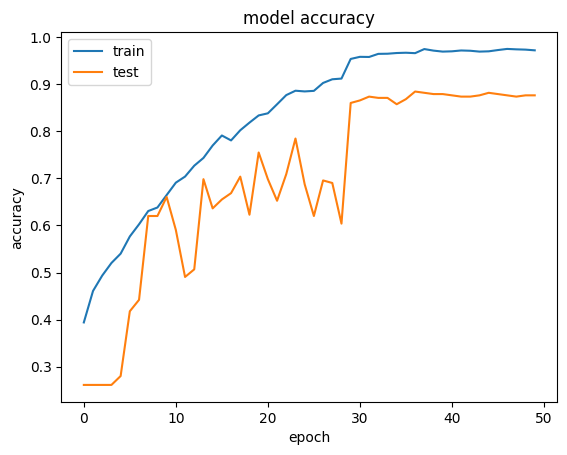

In [23]:
# summarize history for accuracy
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

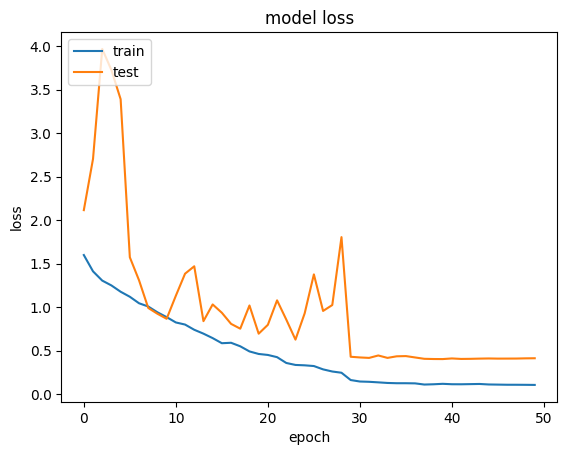

In [24]:
# summarize history for loss
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

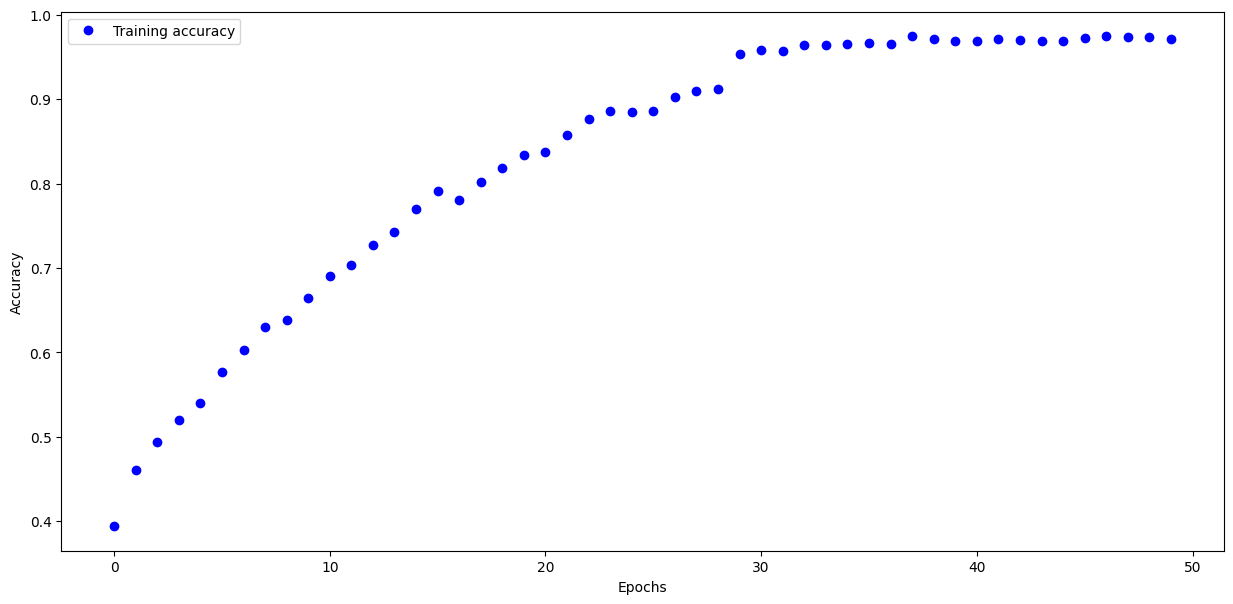

In [25]:
history_dict = history_4.history
Accuracy = history_dict['accuracy']
plt.figure(num=1, figsize=(15,7))
plt.plot(Accuracy,'bo',label='Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
import gc
gc.collect()

1237

In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [11]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[-1]

def model_5():
    model_5 = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(2048, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(4096, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
    ])
    
    model_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model_5

model_5 = model_5()
model_5.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 1022, 126, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1022, 126, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 511, 63, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 509, 61, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 509, 61, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 254, 30, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 252, 28, 128)   │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 252, 28, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 126, 14, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 124, 12, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 124, 12, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2048)           │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │        32,776 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,707,784 (40.85 MB)

 Trainable params: 10,707,304 (40.85 MB)

 Non-trainable params: 480 (1.88 KB)

In [12]:
callbacks = [
    lr_scheduler,
    early_stopping,
    tf.keras.callbacks.ModelCheckpoint('best_model_5.keras', save_best_only=True, monitor='val_accuracy')
]

history_5 = model_5.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks
)
#had 71% training acc ~85% with droupout @0.2 && conv-64-128-256-256-256 && hidden_layers: 512-1024
#next try: conv 32-64-128-128 && hidden_layers: 1024-2048-4096 got 68% with acc~83%
test_loss, test_acc = model_5.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 35s 206ms/step - accuracy: 0.3518 - loss: 1.7157 - val_accuracy: 0.0701 - val_loss: 2.7655 - learning_rate: 1.0000e-04
Epoch 2/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.4525 - loss: 1.4206 - val_accuracy: 0.0701 - val_loss: 5.9857 - learning_rate: 1.0000e-04
Epoch 3/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.5219 - loss: 1.2577 - val_accuracy: 0.1240 - val_loss: 6.5224 - learning_rate: 1.0000e-04
Epoch 4/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.5501 - loss: 1.1867 - val_accuracy: 0.2480 - val_loss: 5.8732 - learning_rate: 1.0000e-04
Epoch 5/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.5775 - loss: 1.1322 - val_accuracy: 0.1914 - val_loss: 5.4014 - learning_rate: 1.0000e-04
Epoch 6/500
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6154 - loss: 0.9994
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - 

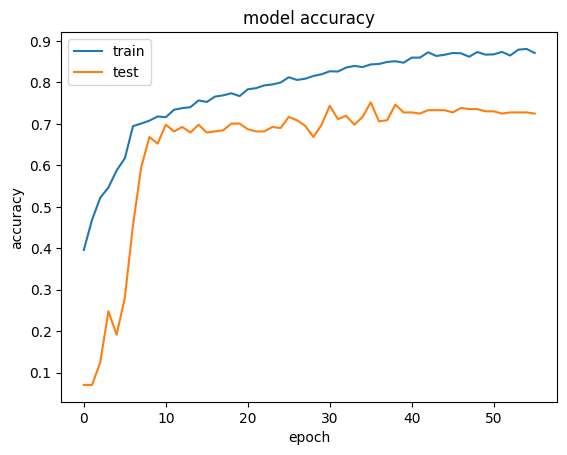

In [13]:
# summarize history for accuracy
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

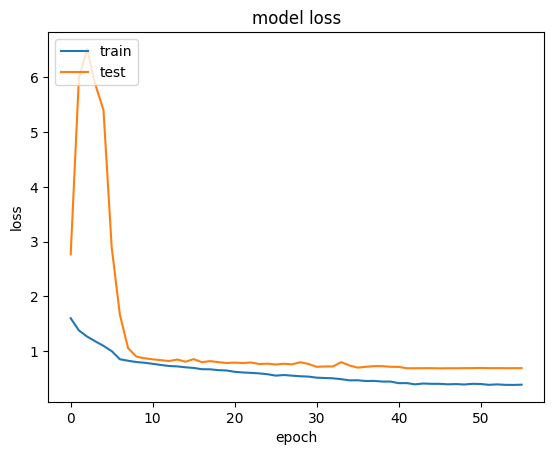

In [14]:
# summarize history for loss
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

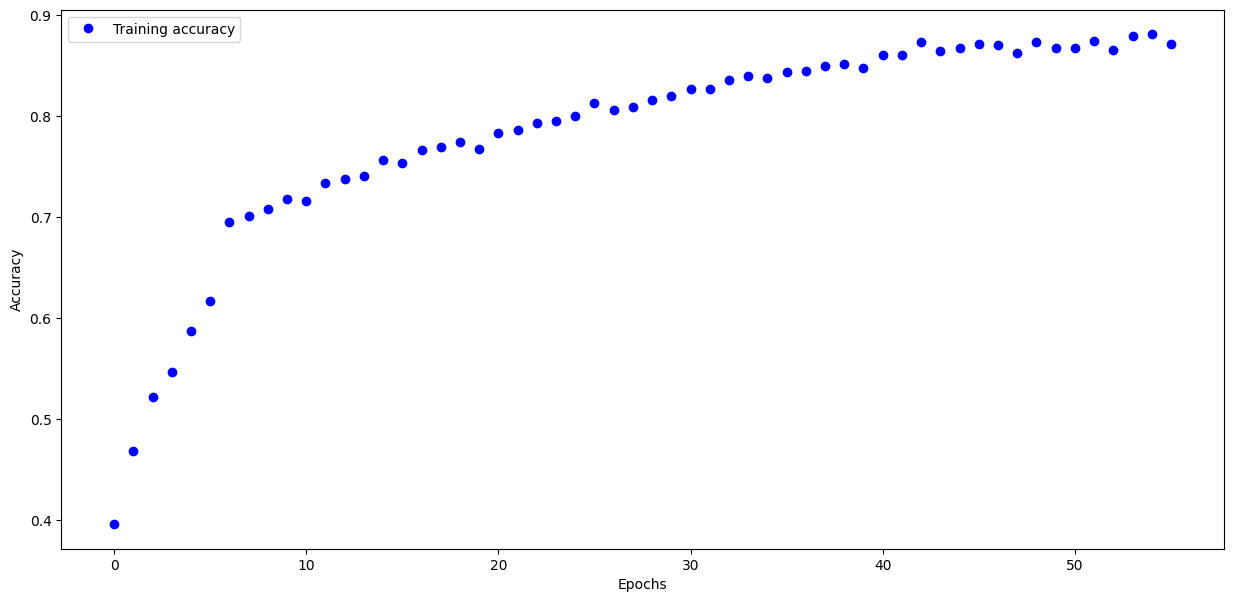

In [15]:
history_dict = history_5.history
Accuracy = history_dict['accuracy']
plt.figure(num=1, figsize=(15,7))
plt.plot(Accuracy,'bo',label='Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [6]:
import gc
gc.collect()

22

In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [8]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[-1]

def model_6():
    model_6 = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(2048, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(4096, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
    ])
    
    model_6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model_6

model_6 = model_6()
model_6.summary()

/home/georgios/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1739745018.417788  257136 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1022, 126, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1022, 126, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 511, 63, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 509, 61, 128)   │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 509, 61, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 254, 30, 128)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 252, 28, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 252, 28, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2048)           │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │        32,776 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,734,184 (44.76 MB)

 Trainable params: 11,733,768 (44.76 MB)

 Non-trainable params: 416 (1.62 KB)

In [9]:
callbacks = [
    lr_scheduler,
    early_stopping,
    tf.keras.callbacks.ModelCheckpoint('best_model_6.keras', save_best_only=True, monitor='val_accuracy')
]

history_6 = model_6.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks
)
#had 70% previous run with training acc arround 85% with dropout @0.5
#76% with train acc ~83% with dropout @0.1
test_loss, test_acc = model_6.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/500


I0000 00:00:1739745021.627145  257311 service.cc:148] XLA service 0x7f2f6c016cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739745021.627174  257311 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
I0000 00:00:1739745021.873706  257311 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/105 ━━━━━━━━━━━━━━━━━━━━ 31:40 18s/step - accuracy: 0.0938 - loss: 2.0750

I0000 00:00:1739745038.254897  257311 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


105/105 ━━━━━━━━━━━━━━━━━━━━ 45s 259ms/step - accuracy: 0.3351 - loss: 1.7788 - val_accuracy: 0.2884 - val_loss: 1.8150 - learning_rate: 1.0000e-04
Epoch 2/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.4323 - loss: 1.5034 - val_accuracy: 0.3989 - val_loss: 2.0751 - learning_rate: 1.0000e-04
Epoch 3/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.4769 - loss: 1.3531 - val_accuracy: 0.3235 - val_loss: 1.9058 - learning_rate: 1.0000e-04
Epoch 4/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.4943 - loss: 1.3293 - val_accuracy: 0.3801 - val_loss: 1.8876 - learning_rate: 1.0000e-04
Epoch 5/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.5259 - loss: 1.2108 - val_accuracy: 0.4259 - val_loss: 1.6603 - learning_rate: 1.0000e-04
Epoch 6/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.5624 - loss: 1.1437 - val_accuracy: 0.4340 - val_loss: 1.4937 - learning_rate: 1.0000e-04
Epoch 7/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step 

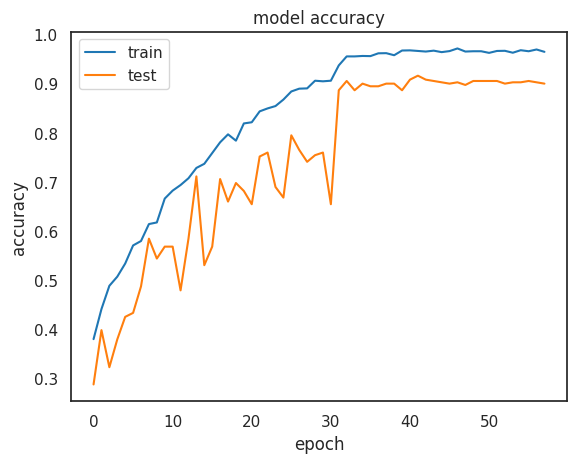

In [10]:
# summarize history for accuracy
plt.plot(history_6.history['accuracy'])
plt.plot(history_6.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

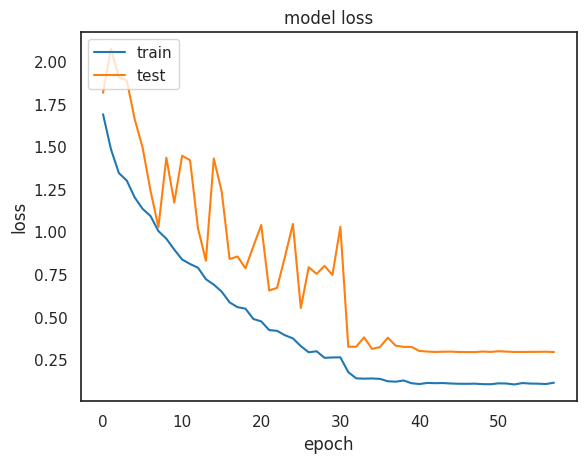

In [11]:
# summarize history for loss
plt.plot(history_6.history['loss'])
plt.plot(history_6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

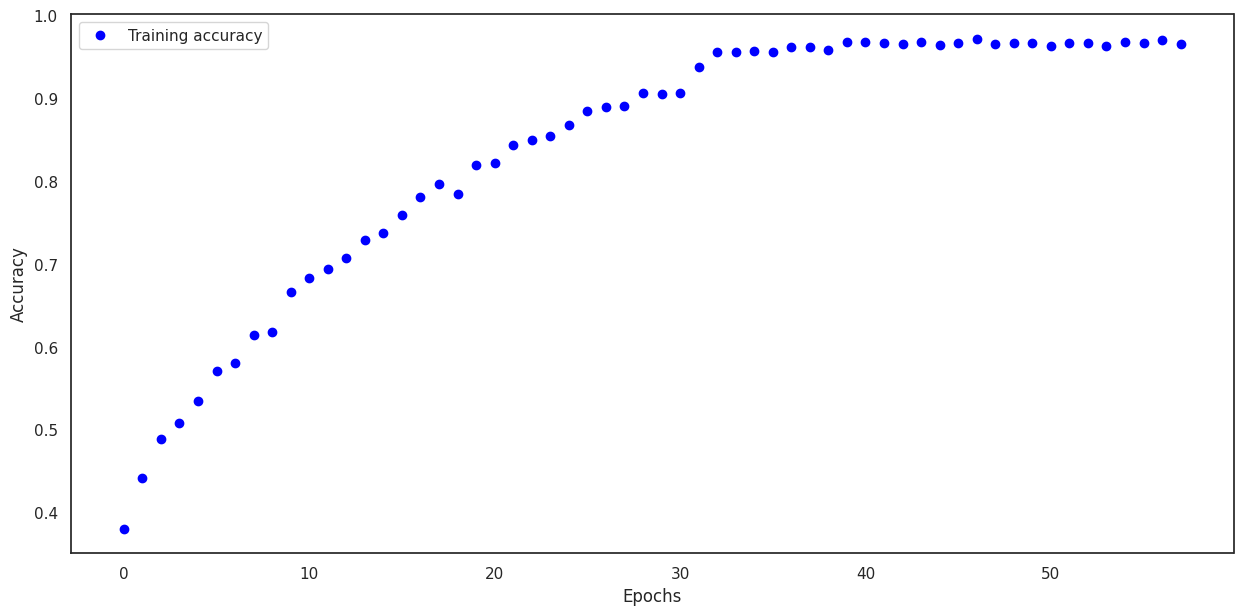

In [12]:
history_dict = history_6.history
Accuracy = history_dict['accuracy']
plt.figure(num=1, figsize=(15,7))
plt.plot(Accuracy,'bo',label='Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
import gc
gc.collect()

7522

In [14]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [15]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[-1]

def model_7():
    model_7 = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(2048, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(4096, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
    ])
    
    model_7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model_7

model_7 = model_7()
model_7.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 1022, 126, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1022, 126, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 511, 63, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 509, 61, 128)   │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 509, 61, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 254, 30, 128)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 252, 28, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 252, 28, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2048)           │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │        32,776 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,734,184 (44.76 MB)

 Trainable params: 11,733,768 (44.76 MB)

 Non-trainable params: 416 (1.62 KB)

In [16]:
callbacks = [
    lr_scheduler,
    early_stopping,
    tf.keras.callbacks.ModelCheckpoint('best_model_7.keras', save_best_only=True, monitor='val_accuracy')
]

history_7 = model_7.fit(
    X_train, y_train,
    epochs=250,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks
)
#had 70% previous run with training acc arround 85% with dropout @0.5
#76% with train acc ~83% with dropout @0.1
test_loss, test_acc = model_7.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.3336 - loss: 1.7903 - val_accuracy: 0.2830 - val_loss: 1.8246 - learning_rate: 1.0000e-04
Epoch 2/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.4151 - loss: 1.5396 - val_accuracy: 0.3989 - val_loss: 1.9000 - learning_rate: 1.0000e-04
Epoch 3/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.4814 - loss: 1.3840 - val_accuracy: 0.3235 - val_loss: 1.8286 - learning_rate: 1.0000e-04
Epoch 4/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.4922 - loss: 1.3103 - val_accuracy: 0.3908 - val_loss: 2.1314 - learning_rate: 1.0000e-04
Epoch 5/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.5200 - loss: 1.2308 - val_accuracy: 0.4367 - val_loss: 1.6436 - learning_rate: 1.0000e-04
Epoch 6/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.5487 - loss: 1.1463 - val_accuracy: 0.5121 - val_loss: 1.2929 - learning_rate: 1.0000e-04
Epoch 7/250
105/105 ━━━━━━━━━━━━━━━━━━━━ 11

In [ ]:
# Evaluate the model 80% acc, 82% test acc, loss 0.61
loss, acc = model_best.evaluate(X_test, y_test, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
# Loads the weights
model_best.load_weights('best_model.h5')

# Re-evaluate the model
loss, acc = model_best.evaluate(X_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [17]:
gc.collect()

1069

In [18]:
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)